In [176]:
# Load modules
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import cv2
import os
import re
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [47]:
target_size = 299 # For inception

In [48]:
def enhanceAndReshape(img):
    img_arr = np.asarray(img)
    # Cut lower part (Engine hood)
    remaining = 80
    img2=(img_arr[0:int(img_arr.shape[0]/2+remaining),
             0:img_arr.shape[1]]).copy()
    
    # Histogram equalization
    img2[:, :, 0] = cv2.equalizeHist(img2[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img2[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img2[:, :, 2])
    
    return cv2.resize(img2, (target_size, target_size))

(299, 299, 3)


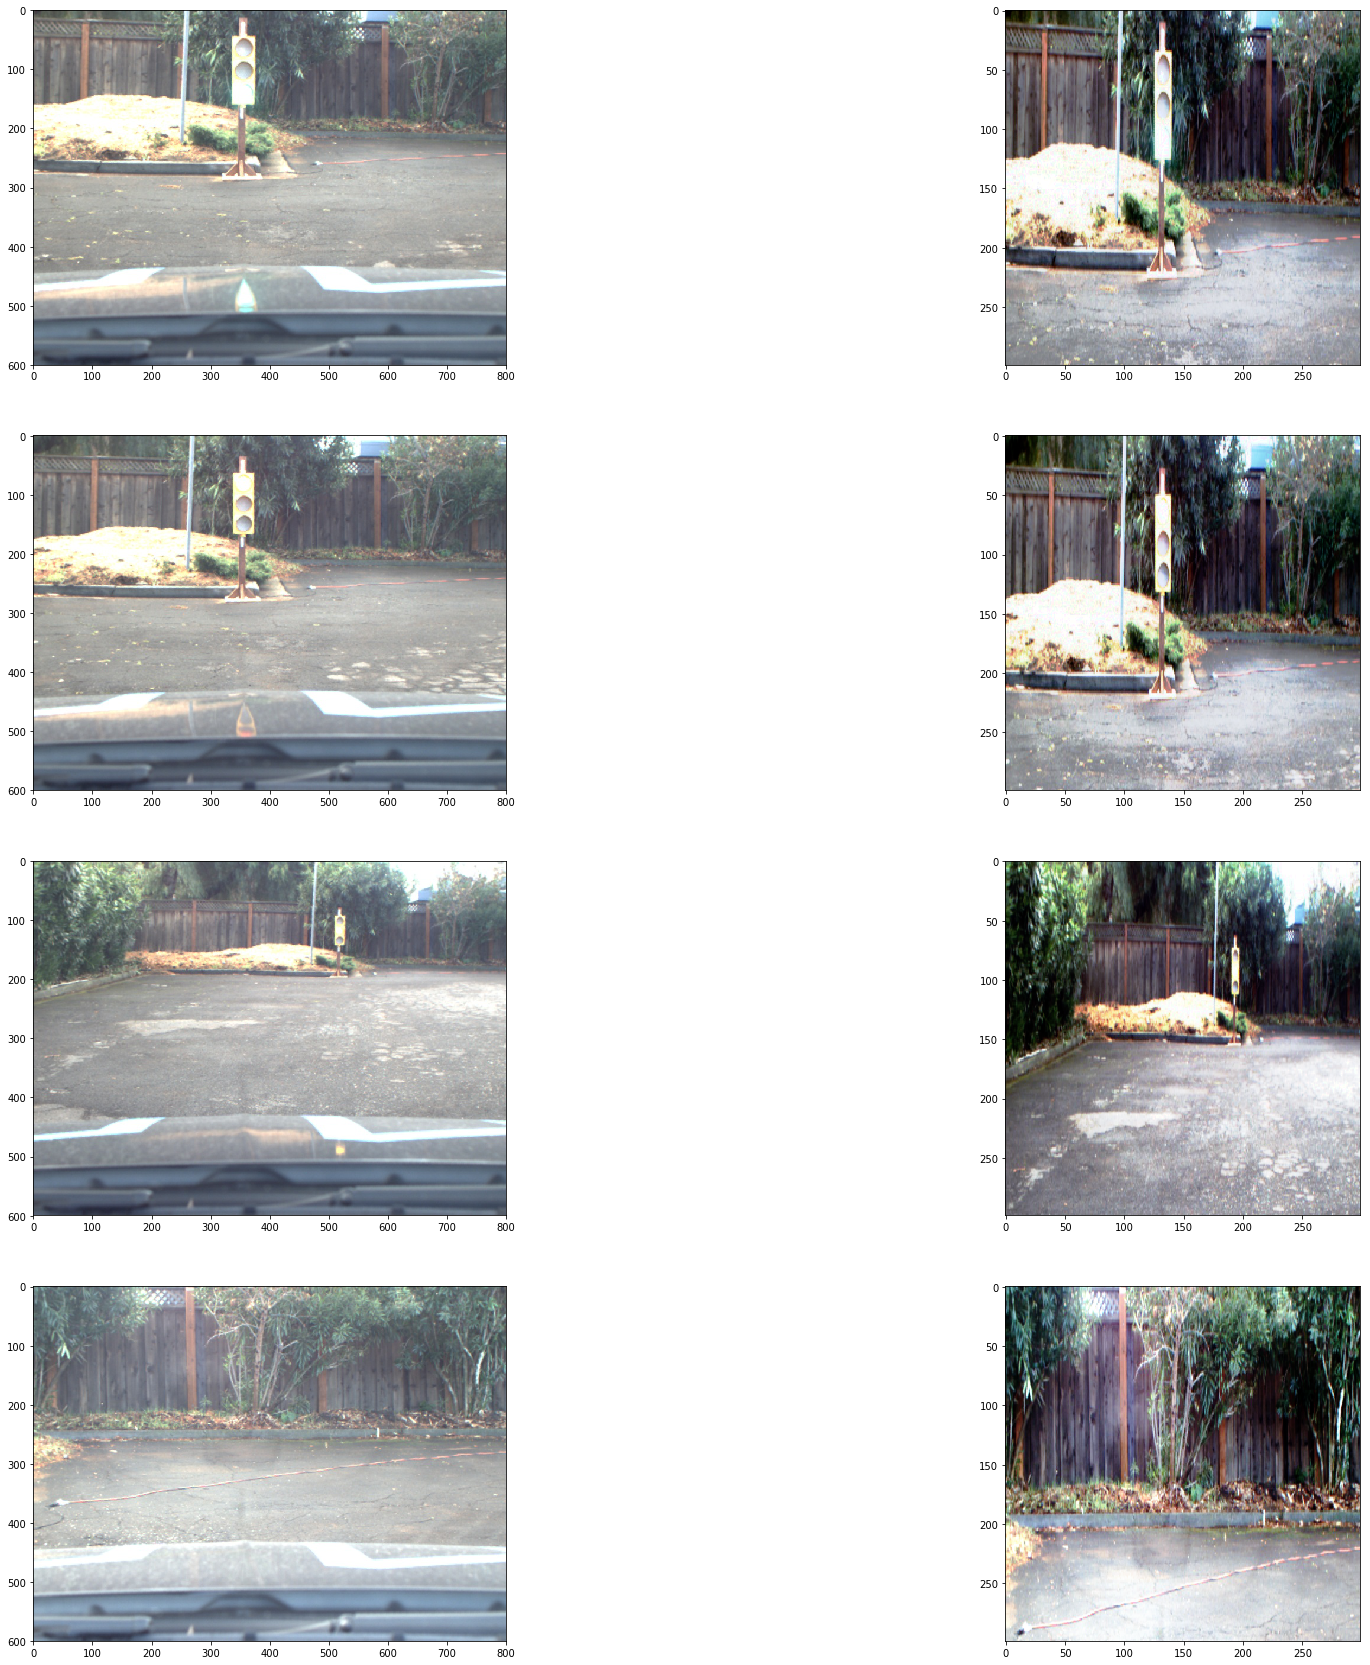

In [184]:
green_light_training_dir = os.path.join('ros_bag_1', 'Green')
green_light_training_data = [os.path.join(green_light_training_dir, f) for f in os.listdir(green_light_training_dir) if re.match(r'[0-9]+.*\.jpg', f)]
#print('Green light training image paths:', green_light_training_data)
plt.figure(figsize=(30,30))
plt.subplot(4, 2, 1)
green_light_sample = load_img(green_light_training_data[100])
plt.imshow(green_light_sample) #Pick a image to show
plt.subplot(4, 2, 2)
green_enhanced = enhanceAndReshape(green_light_sample)
plt.imshow(green_enhanced)

red_light_training_dir = os.path.join('ros_bag_1', 'Red')
red_light_training_data = [os.path.join(red_light_training_dir, f) for f in os.listdir(red_light_training_dir) if re.match(r'[0-9]+.*\.jpg', f)]
plt.subplot(4, 2, 3)
red_light_sample = load_img(red_light_training_data[100])
plt.imshow(red_light_sample) #Pick a image to show
plt.subplot(4, 2, 4)
red_enhanced = enhanceAndReshape(red_light_sample)
plt.imshow(red_enhanced)

yellow_light_training_dir = os.path.join('ros_bag_1', 'Yellow')
yellow_light_training_data = [os.path.join(yellow_light_training_dir, f) for f in os.listdir(yellow_light_training_dir) if re.match(r'[0-9]+.*\.jpg', f)]
plt.subplot(4, 2, 5)
yellow_light_sample = load_img(yellow_light_training_data[100])
plt.imshow(yellow_light_sample) #Pick a image to show
plt.subplot(4, 2, 6)
yellow_enhanced = enhanceAndReshape(yellow_light_sample)
plt.imshow(yellow_enhanced)

no_light_training_dir = os.path.join('ros_bag_1', 'No_Light')
no_light_training_data = [os.path.join(no_light_training_dir, f) for f in os.listdir(no_light_training_dir) if re.match(r'[0-9]+.*\.jpg', f)]
plt.subplot(4, 2, 7)
no_light_sample = load_img(no_light_training_data[100])
plt.imshow(no_light_sample) #Pick a image to show
plt.subplot(4, 2, 8)
no_light_enhanced = enhanceAndReshape(no_light_sample)
plt.imshow(no_light_enhanced)

print(np.shape(no_light_enhanced))
plt.show()

In [51]:
inception_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(target_size,target_size,3))
inception_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_95 (Convolution2D) (None, 149, 149, 32)  896         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_95 (BatchNorm (None, 149, 149, 32)  128         convolution2d_95[0][0]           
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 147, 147, 32)  9248        batchnormalization_95[0][0]      
___________________________________________________________________________________________

In [69]:
model = models.Sequential()
model.add(inception_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inception_v3 (Model)             (None, 8, 8, 2048)    21611968                                     
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 131072)        0           mixed10[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 256)           33554688    flatten_3[0][0]                  
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 4)             1028        dense_5[0][0]                    
Total params: 55,167,684
Trainable params: 55,133,444
Non-trainable params: 34,240
________

In [164]:
image_paths = green_light_training_data + red_light_training_data + yellow_light_training_data + no_light_training_data
labels = [0] * len(green_light_training_data) + [1] * len(red_light_training_data) + [2] * len(yellow_light_training_data) + [3] * len(no_light_training_data)
print(np.shape(image_paths))
print(np.shape(labels))

(4446,)
(4446,)


In [173]:
# Split image paths and category into training, validation and test sets
images_train, images_test, labels_train, labels_test = train_test_split(image_paths, labels, test_size=0.05, random_state=42)
images_train, images_valid, labels_train, labels_valid = train_test_split(images_train, labels_train, test_size=0.15, random_state=42)

print('Training data size:', np.shape(images_train))
print('Validation data size:', np.shape(images_valid))
print('Testing data size:', np.shape(images_test))

print('Training label size:', np.shape(labels_train))
print('Validation label size:', np.shape(labels_valid))
print('Testing label size:', np.shape(labels_test))

Training data size: (3589,)
Validation data size: (634,)
Testing data size: (223,)
Training label size: (3589,)
Validation label size: (634,)
Testing label size: (223,)


In [179]:
def data_generator(images, labels, batch_size):
    x, predict = ([],[])
    images, labels = shuffle(images, labels)
    while True:
        for i in range(len(labels)):
            img = enhanceAndReshape(load_img(images[i]))
            label = labels[i]
            x.append(img)
            predict.append(label)
            if len(x) == batch_size:
                yield (np.array(x), to_categorical(np.array(predict), 4))
                x, predict = ([],[])
                images, labels = shuffle(images, labels)
            # Flip to enrich training data
            x.append(cv2.flip(img, 1))
            predict.append(label)
            if len(x) == batch_size:
                yield (np.array(x), to_categorical(np.array(predict), 4))
                x, predict = ([],[])
                images, labels = shuffle(images, labels)

In [180]:
# Fine-tune model with very small learning rate
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
            loss='categorical_crossentropy',
            metrics=['acc'])
generator = data_generator(images_train, labels_train, 32)
validation_generator = data_generator(images_valid, labels_valid, 32)
for inputs_batch, labels_batch in generator:
    print(np.shape(inputs_batch))
    print(np.shape(labels_batch))
    print(np.shape(inputs_batch[0]))
    print(labels_batch[0])
    break;
for inputs_batch, labels_batch in validation_generator:
    print(np.shape(inputs_batch))
    print(np.shape(labels_batch))
    print(np.shape(inputs_batch[0]))
    print(labels_batch[0])
    break;

(32, 299, 299, 3)
(32, 4)
(299, 299, 3)
[ 0.  0.  1.  0.]
(32, 299, 299, 3)
(32, 4)
(299, 299, 3)
[ 0.  1.  0.  0.]


In [181]:

history = model.fit_generator(generator, 
                              validation_data = validation_generator,
                              samples_per_epoch=3200, 
                              nb_val_samples=800,
                              nb_epoch=10,
                              verbose=1)                

Epoch 1/10
3200/3200 [==============================] - 4239s - loss: 0.8070 - acc: 0.7987 - val_loss: 0.8386 - val_acc: 0.7150

TypeError: evaluate_generator() missing 1 required positional argument: 'val_samples'

In [183]:
print('Eventual Loss: ', model.evaluate_generator(data_generator(images_test, labels_test, 32), val_samples = 320))

Eventual Loss:  [0.083087432571088013, 0.98124999999999996]


In [182]:
model.save('inceptionv3_based_ros1_trained.h5')

0


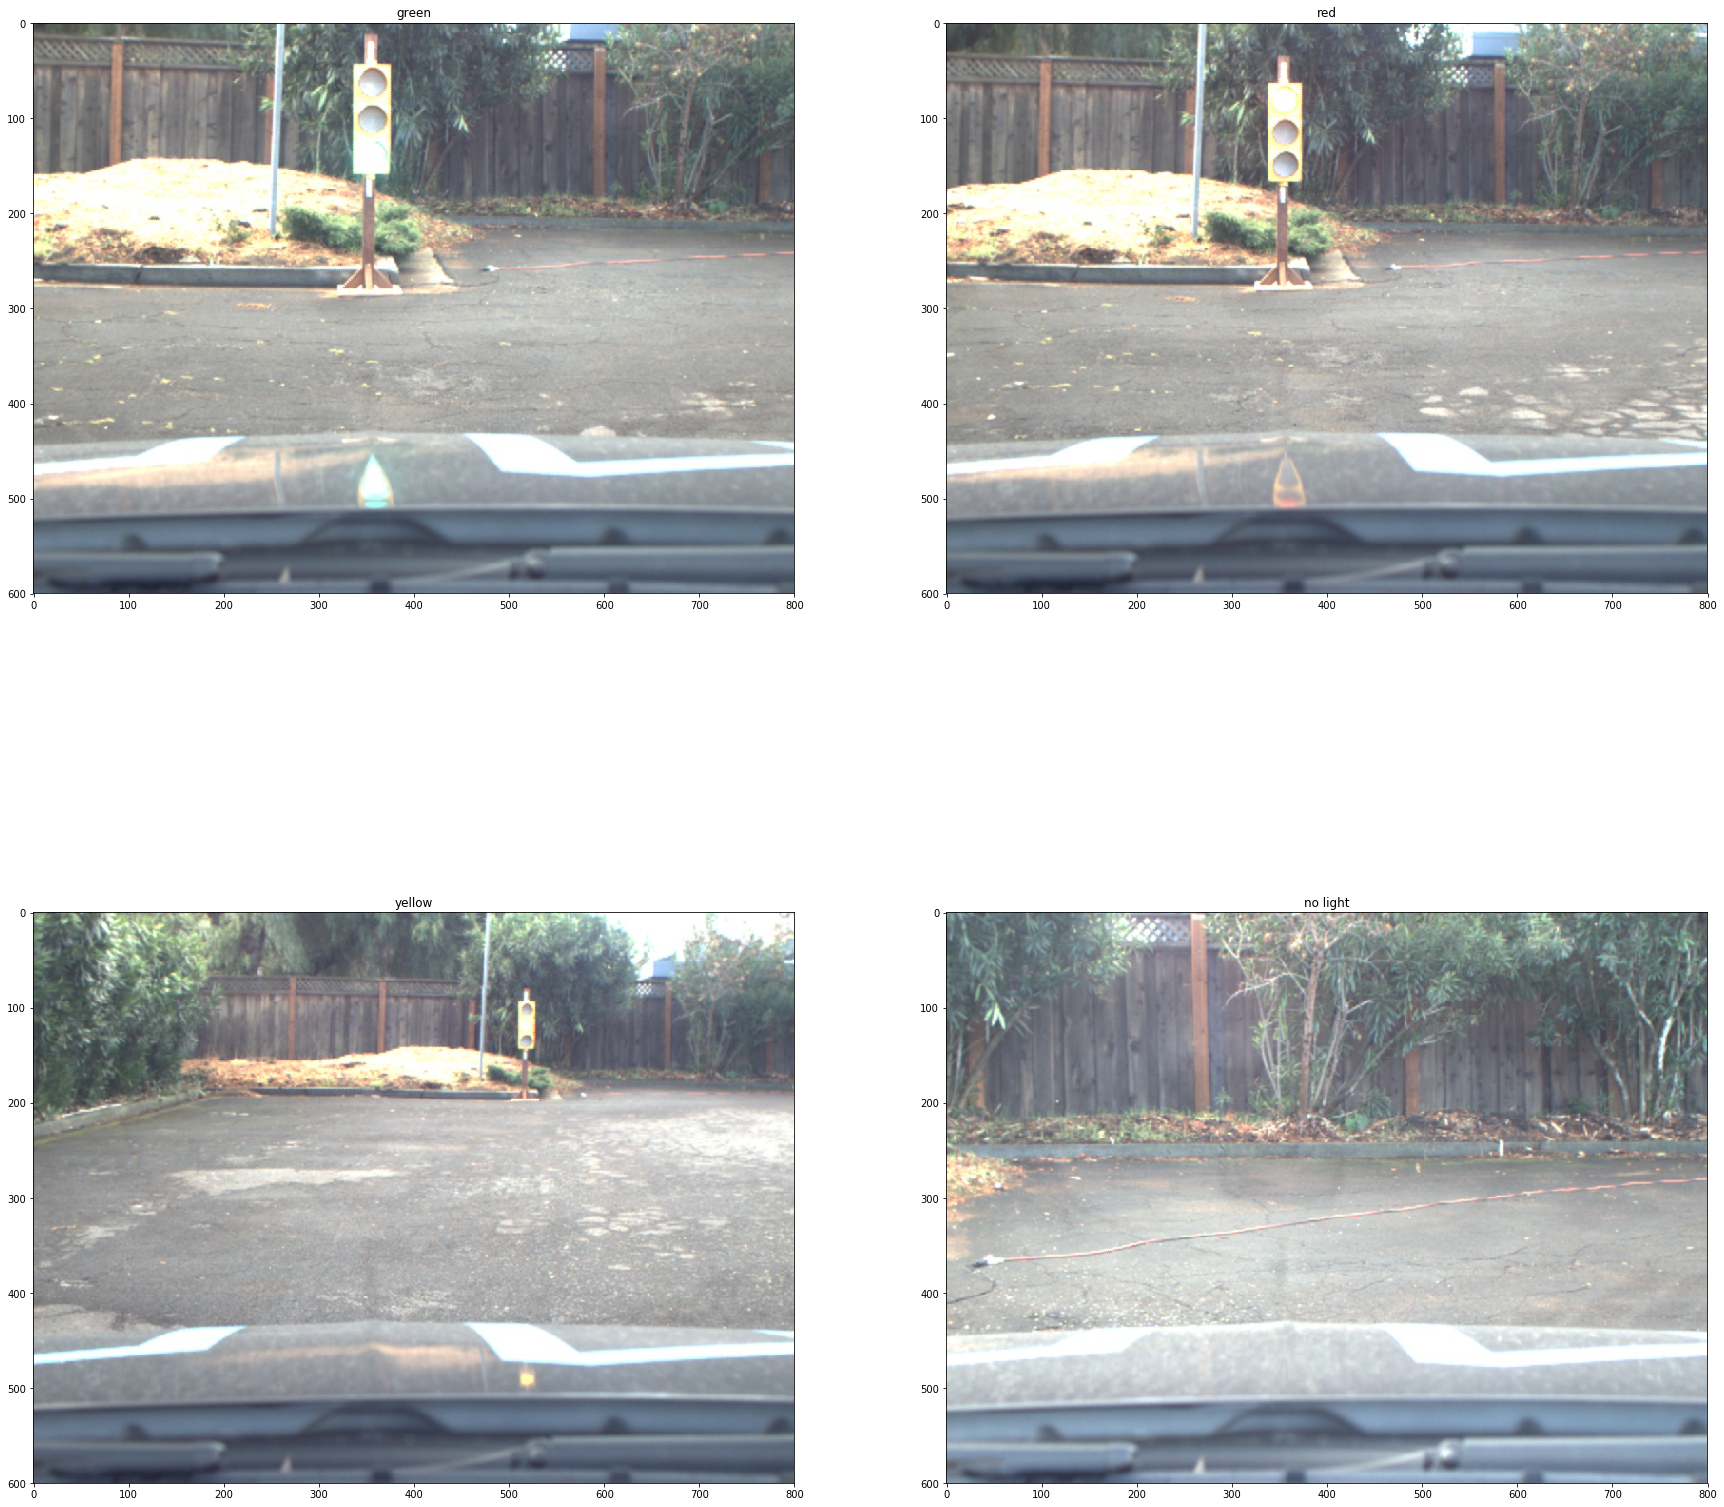

In [201]:
predicted = ['green', 'red', 'yellow', 'no light']
state = model.predict(np.expand_dims(green_enhanced, axis=0))
idx = np.argmax(state)
plt.figure(figsize=(30,30))
plt.subplot(2, 2, 1)
plt.title(predicted[idx])
plt.imshow(green_light_sample)


state = model.predict(np.expand_dims(red_enhanced, axis=0))
idx = np.argmax(state)
plt.subplot(2, 2, 2)
plt.title(predicted[idx])
plt.imshow(red_light_sample)


state = model.predict(np.expand_dims(yellow_enhanced, axis=0))
idx = np.argmax(state)
plt.subplot(2, 2, 3)
plt.title(predicted[idx])
plt.imshow(yellow_light_sample)


state = model.predict(np.expand_dims(no_light_enhanced, axis=0))
idx = np.argmax(state)
plt.subplot(2, 2, 4)
plt.title(predicted[idx])
plt.imshow(no_light_sample)

plt.show()